In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; 
}

<IPython.core.display.Javascript object>

In [8]:
import pandas as pd
#raw = pd.pandas.read_csv('20170101_raw.csv',sep=";")
#raw = pd.pandas.read_csv('20180608_raw_geo.csv',sep=",",low_memory=False)
#raw = pd.pandas.read_csv('20180815_raw_geo.csv',sep=",",low_memory=False)
raw = pd.pandas.read_csv('20181114_raw_geo.csv',sep=",",low_memory=False)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy import stats
print("imported " + str(len(raw)) + " rows")
raw.columns.tolist()

imported 68204 rows


['booli_id',
 'published',
 'sold_date',
 'object_type',
 'living_area',
 'rooms',
 'floor',
 'rent',
 'list_price',
 'sold_price',
 'sold_price_source',
 'construction_year',
 'address_street_address',
 'region_municipality_name',
 'region_county_name',
 'url',
 'apartment_number',
 'distance_ocean',
 'source_name',
 'source_url',
 'source_type',
 'source_id',
 'position_longitude',
 'position_latitude',
 'additional_area',
 'location_named_areas',
 'plot_area',
 'min_distance_to_metro',
 'area_from_geo']

In [15]:
##############################
####    var cleaning     #####
##############################
input = ['living_area','sold_price']
print(len(raw))
clean = raw
clean = clean[pd.notnull(raw[input]).all(axis=1)] #rowsum booleans for nullvals in col
#clean = raw[pd.notnull(raw['living_area']) & pd.notnull(raw['rooms']) & pd.notnull(raw['floor']) & pd.notnull(raw['sold_price']) & pd.notnull(raw['min_distance_to_metro'])]
print("Removed " +str(len(raw)-len(clean)) + " rows with nulls")
print(len(clean))

##############################
#### additional features #####
##############################
sqm_sold_price =  pd.DataFrame({'sqm_sold_price':clean.sold_price / clean.living_area}) 
sqm_sold_rent =  pd.DataFrame({'sqm_sold_rent':clean.rent / clean.living_area})
sqm_list_price =  pd.DataFrame({'sqm_list_price':clean.list_price / clean.living_area}) 
sqm_price_increase =  pd.DataFrame({'sqm_price_increase':(clean.sold_price-clean.list_price) / clean.living_area})
clean = pd.concat([clean , sqm_sold_price, sqm_sold_rent, sqm_price_increase, sqm_list_price], axis=1)

# time features
#https://pandas.pydata.org/pandas-docs/stable/timeseries.html
sold_datetime =  pd.DataFrame({'sold_datetime': pd.to_datetime(clean['sold_date'])})
published_datetime =  pd.DataFrame({'published_datetime': pd.to_datetime(clean['published'])})
clean = pd.concat([clean , sold_datetime,published_datetime], axis=1)

sold_year = pd.DataFrame({'sold_year': clean['sold_datetime'].dt.year})
sold_month_nbr = pd.DataFrame({'sold_month_nbr': clean['sold_datetime'].dt.month})
sold_year_month = pd.DataFrame({'sold_year_month': clean['sold_datetime'].dt.year*100 + clean['sold_datetime'].dt.month})

def get_year_month_period(row): return (row["sold_datetime"].strftime("%Y-%m-01"))
sold_year_month_period = pd.DataFrame({'sold_year_month_period': clean.apply(get_year_month_period, axis=1)})

def get_week(row): return row['sold_datetime'].isocalendar()[1]
sold_week = pd.DataFrame({'sold_week': clean.apply(get_week, axis=1)})


def get_days_on_market(row): return (row['sold_datetime'] - row['published_datetime']).days
days_on_market = pd.DataFrame({'days_on_market': clean.apply(get_days_on_market, axis=1)})
def weekday(row): return (row.dayofweek)
sold_weekday = pd.DataFrame({'sold_weekday': clean['sold_datetime'].apply(weekday)})
published_weekday = pd.DataFrame({'published_weekday': clean['published_datetime'].apply(weekday)})



clean = pd.concat([clean , sold_year,sold_month_nbr,sold_year_month, sold_week,days_on_market,sold_weekday,published_weekday,sold_year_month_period], axis=1)

##############################
####   remove outliers   #####
##############################
#remove june 2018 transactions
# only look at top 9 areas
num = len(clean)
#clean = clean[clean.sold_datetime < '2018-11-15']
areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
clean = clean[clean['area_from_geo'].isin(areas)]

num = len(clean)
before = num
important_vars = ['living_area','floor','sqm_sold_price','distance_ocean','sqm_sold_rent','construction_year','days_on_market']
for i in important_vars:
    q_u = clean[i].quantile(0.995)
    q_l = clean[i].quantile(0.005)
    clean = clean[(clean[i] < q_u) | (pd.isnull(clean[i]))]
    clean = clean[(clean[i] > q_l) | (pd.isnull(clean[i]))]
    print(str(round(q_l,1)) + "\t < var < \t" + str(round(q_u,1)) + ". "+ i + ' - ' + str(num - len(clean)) + " removed.")
    num = len(clean)
print("bedore: " + str(before) + ", after: " + str(len(clean)))

68204
Removed 146 rows with nulls
68058
19.0	 < var < 	175.0. living_area - 403 removed.
0.0	 < var < 	13.0. floor - 1064 removed.
38961.0	 < var < 	135461.0. sqm_sold_price - 353 removed.
218.0	 < var < 	4649.0. distance_ocean - 351 removed.
10.4	 < var < 	83.6. sqm_sold_rent - 344 removed.
1879.0	 < var < 	2017.0. construction_year - 420 removed.
0.0	 < var < 	175.0. days_on_market - 422 removed.
bedore: 36536, after: 33179


## Variable Plot

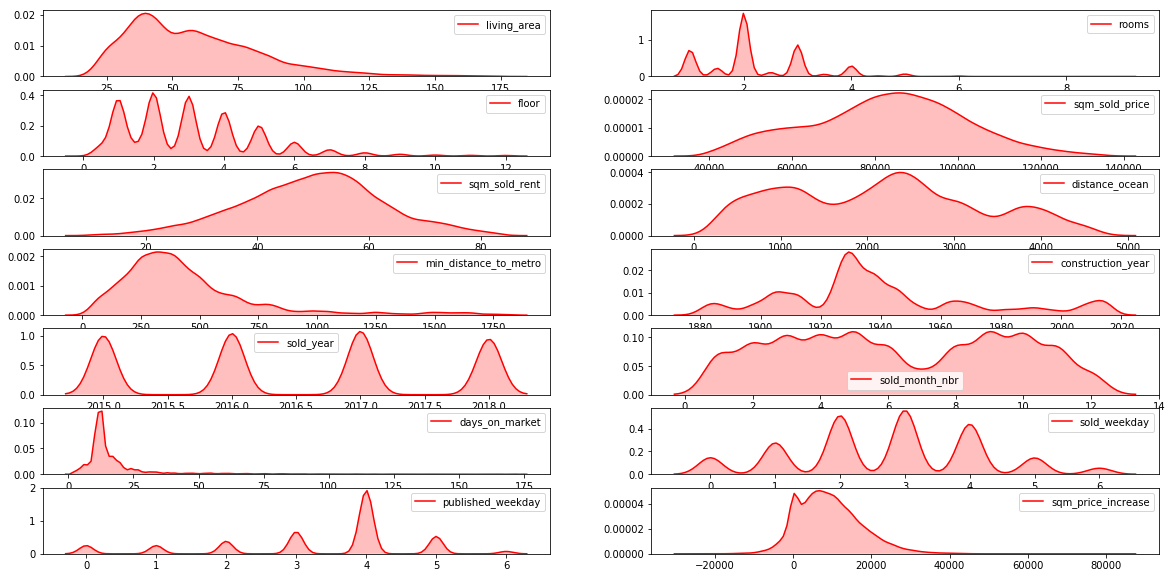

In [16]:
plot_vars = ['living_area','rooms','floor','sqm_sold_price','sqm_sold_rent','distance_ocean','min_distance_to_metro','construction_year','sold_year','sold_month_nbr','days_on_market','sold_weekday','published_weekday','sqm_price_increase']

plt.subplots(figsize=(20,10))
for i in range(1,len(plot_vars)+1):
    data = clean[pd.notnull(clean[plot_vars[i-1]])][plot_vars[i-1]] # remove null values for the var plot
    plt.subplot(math.ceil(len(plot_vars)/2),2,i)
    sns.kdeplot(data,shade=True, color="r", bw='scott')#bw=math.sqrt(len(clean[plot_vars[i-1]].unique()))/10)

plt.show()
# also see: https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
# and https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html

#plot_vars_grid = ['living_area','rooms','floor','sqm_sold_price','sqm_sold_rent','min_distance_to_metro']
#g = sns.PairGrid(clean[plot_vars])
#g = g.map_upper(plt.scatter)
#g = g.map_lower(sns.kdeplot, cmap="Blues_d")
#g = g.map_diag(sns.kdeplot, lw=3, legend=False)
#plt.show()

## Timeseries Plots

In [18]:
##define plot function and top 10 areas
#http://pandas.pydata.org/pandas-docs/version/0.16.2/generated/pandas.core.groupby.DataFrameGroupBy.plot.html
def timeseries_plot(plot_data,title,x_lab, y_lab):
    plt.plot(plot_data)
    plt.title(title)
    plt.ylabel(y_lab)
    plt.xlabel(x_lab)
    plt.legend(list(plot_data.columns.values))

## Price/sqm year over year

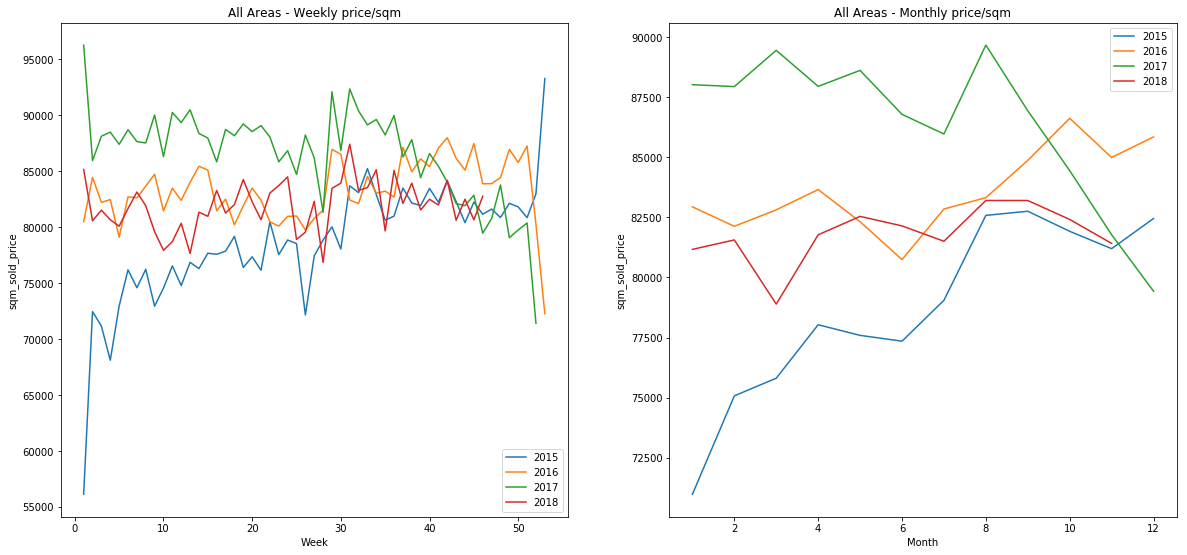

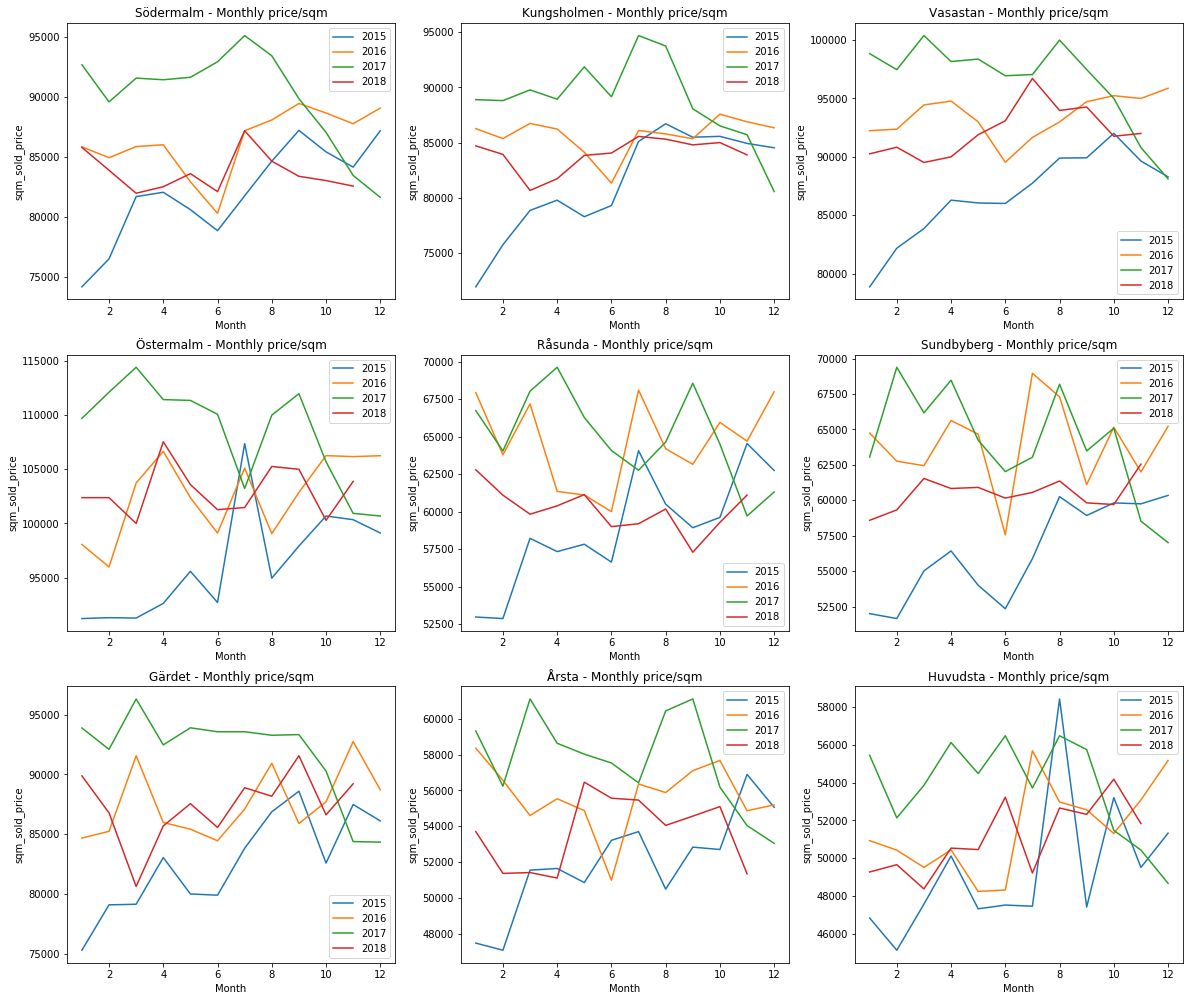

In [19]:
plt.subplots(figsize=(20,20))
plt.subplot(2,2,1)
timeseries_plot(clean.groupby(['sold_week','sold_year']).mean()['sqm_sold_price'].unstack(),"All Areas - Weekly price/sqm", "Week", "sqm_sold_price")
plt.subplot(2,2,2)
timeseries_plot(clean.groupby(['sold_month_nbr','sold_year']).mean()['sqm_sold_price'].unstack(),"All Areas - Monthly price/sqm", "Month", "sqm_sold_price")


areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
plt.subplots(figsize=(20,60))
for i in range(0,len(areas)):
    plt.subplot(10,3,i+1)
    plot_data = clean[(clean.area_from_geo == areas[i])].groupby(['sold_month_nbr','sold_year']).median()['sqm_sold_price'].unstack()
    #plot_data = clean[(clean.area_from_geo == areas[i]) & (clean.living_area < 65) & (clean.living_area > 30) ].groupby(['month_nbr','year']).mean()['sqm_price'].unstack()
    timeseries_plot(plot_data, areas[i] + " - Monthly price/sqm", "Month", "sqm_sold_price")
    
plt.show()



## Sold Count year over year

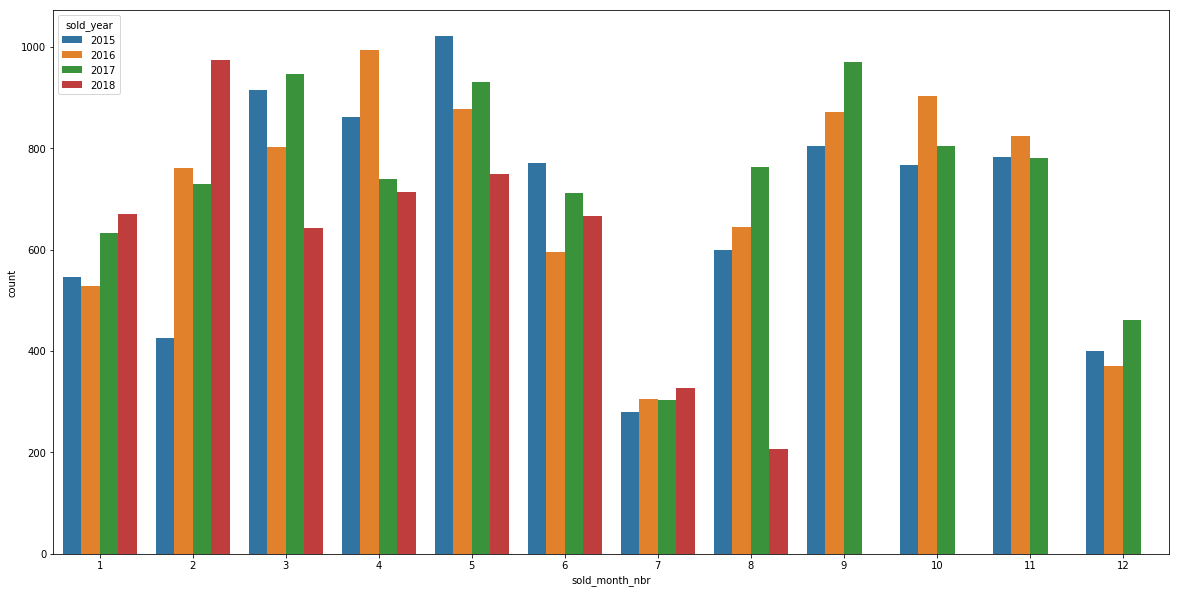

In [13]:
plt.subplots(figsize=(20,10))
sns.countplot(x="sold_month_nbr", hue="sold_year", data=clean)

#areas = clean.groupby(['area_from_geo']).size().nlargest(9).index.values
#plt.subplots(figsize=(20,60))
#for i in range(0,len(areas)):
#    plt.subplot(10,3,i+1)    
#    plot_data = clean[(clean.area_from_geo == areas[i])].groupby(['sold_month_nbr','sold_year']).count()['sqm_price'].unstack()
#    timeseries_plot(plot_data, areas[i] + " - Monthly num sold", "Month", "count")
    
plt.show()


## Bivariate Plot

Södermalm


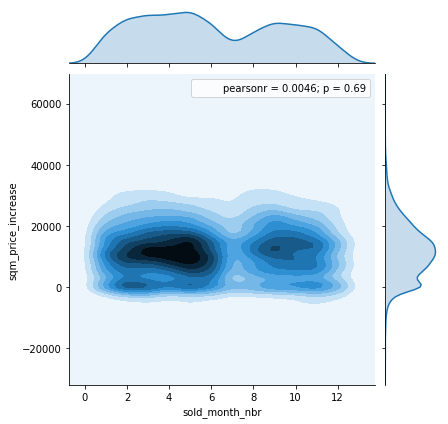

Kungsholmen


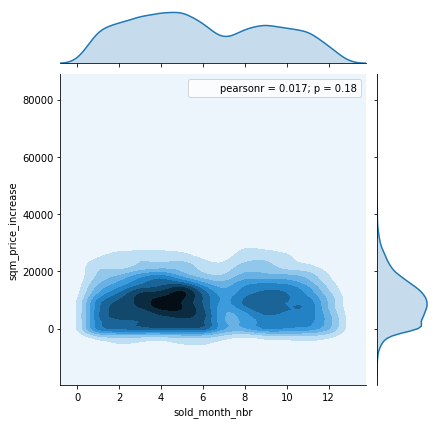

Vasastan


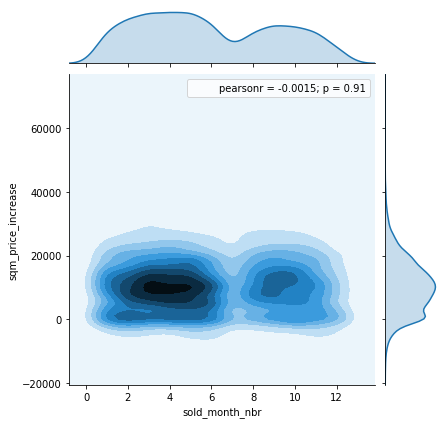

Östermalm


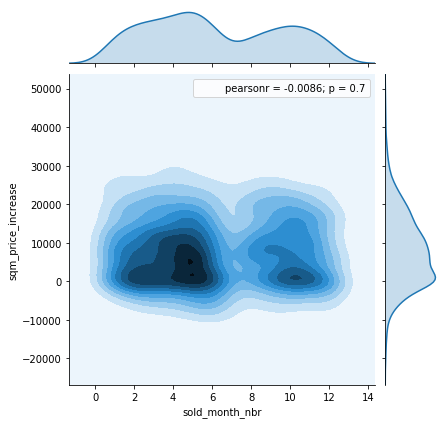

Råsunda


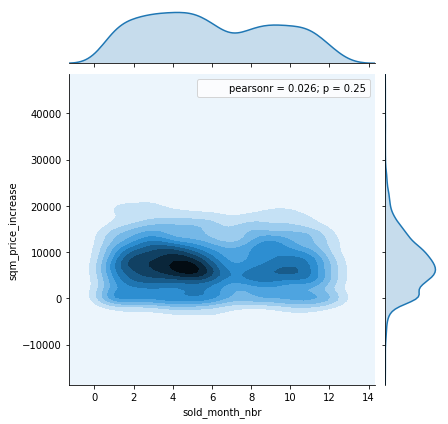

Sundbyberg


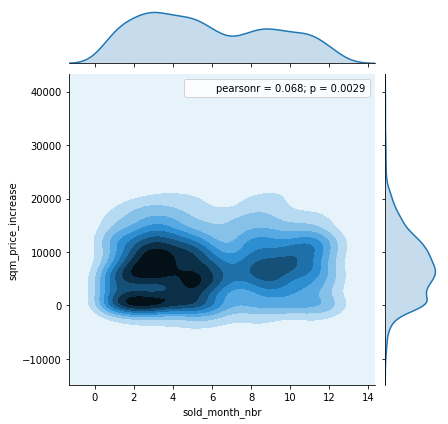

Gärdet


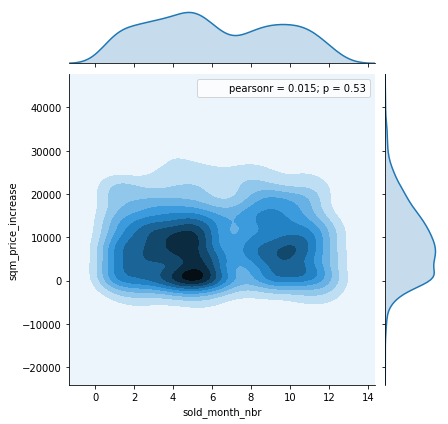

Årsta


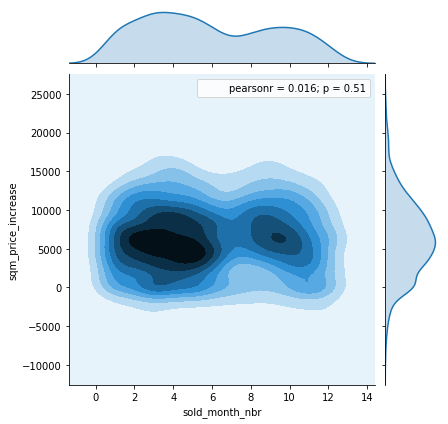

Huvudsta


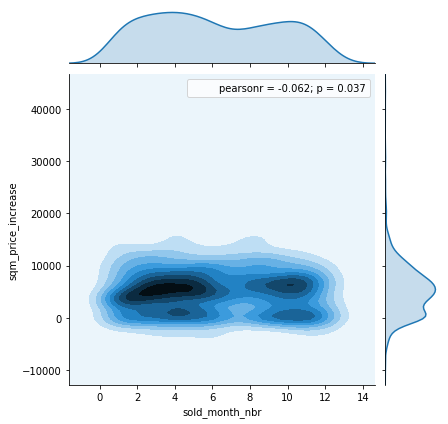

In [14]:
#price increase

for i in areas:
    print(i)
    sns.jointplot(x="sold_month_nbr", y="sqm_price_increase", data=clean[(clean['area_from_geo'] == i) & (clean['sold_year'] > 2000 ) ], kind="kde")
    plt.show()
    

#published weekday
#sns.jointplot(x="published_weekday", y="sqm_price", data=clean[(clean['sold_year'] == 2017) ], kind="kde")

# days on market
#sns.jointplot(x="days_on_market", y="sqm_price", data=clean[(clean['days_on_market'] < 7) & (clean['sold_year'] == 2017) ], kind="kde");
#sns.jointplot(x="days_on_market", y="sqm_price", data=clean[(clean['days_on_market'] > 30)& (clean['days_on_market'] < 90) & (clean['sold_year'] == 2017) ], kind="kde");

## contruction year vs (price/rent)
#sns.jointplot(x="construction_year", y="sqm_sold_rent", data=clean, kind="kde");
#sns.jointplot(x="construction_year", y="sqm_price", data=clean, kind="kde");


#sns.jointplot(x="sqm_sold_rent", y="sqm_price", data=clean, kind="kde");
#sns.jointplot(x="min_distance_to_metro", y="sqm_price", data=clean, kind="kde");


# not so nice
#sns.jointplot(x="month_nbr", y="sqm_price", data=clean, kind="kde");

In [617]:
areas[1:2]

array(['Kungsholmen'], dtype=object)

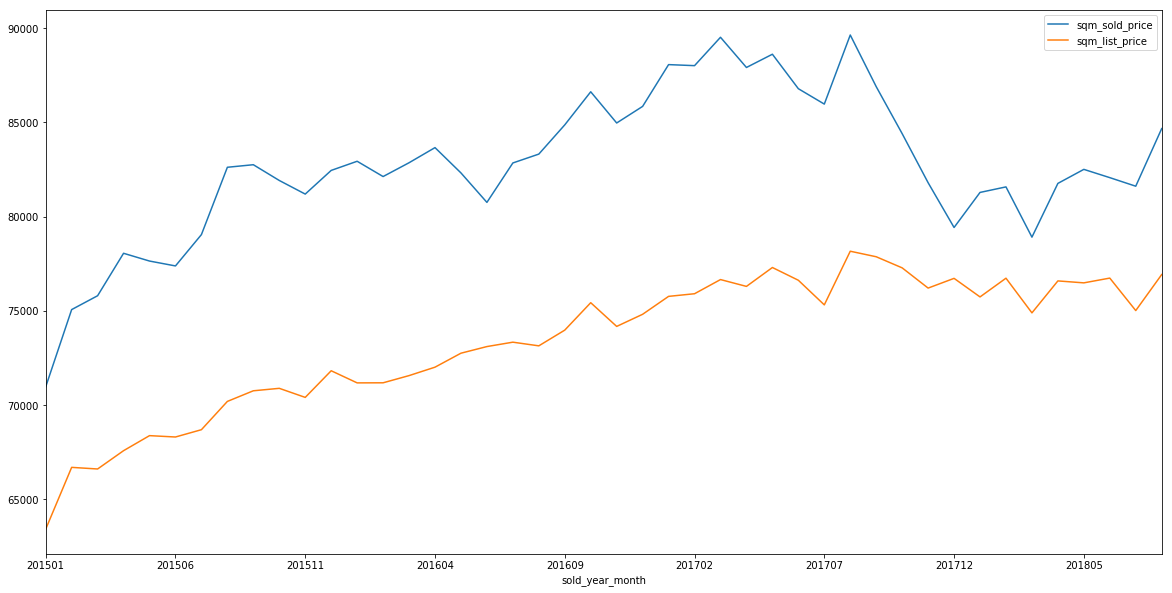

Södermalm


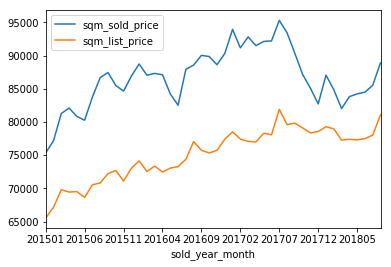

Kungsholmen


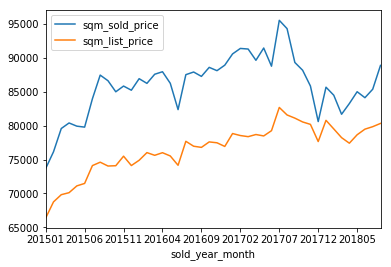

Vasastan


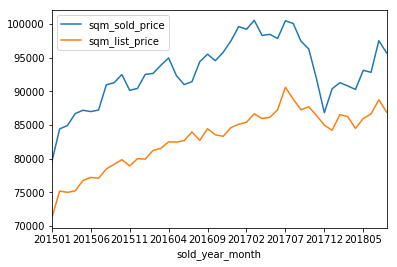

Östermalm


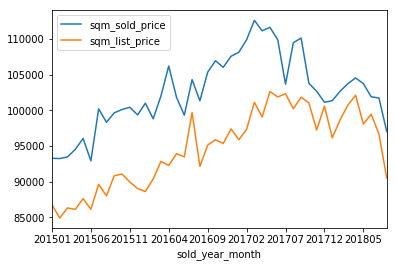

Råsunda


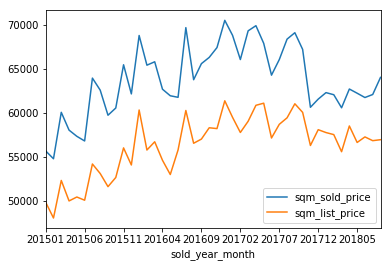

Sundbyberg


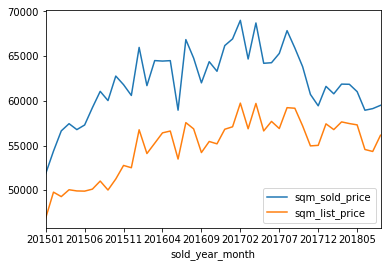

Gärdet


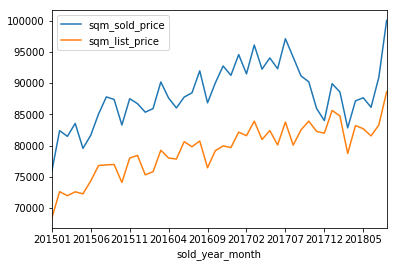

Årsta


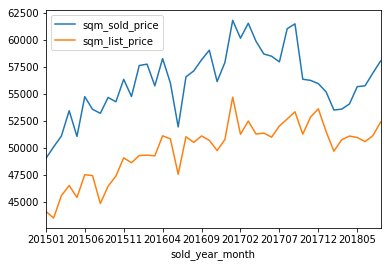

Huvudsta


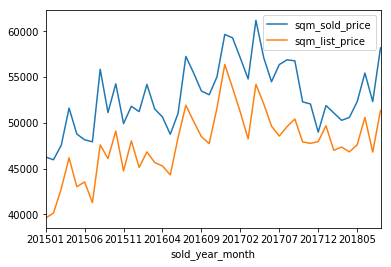

In [52]:
a = clean.groupby(['sold_year_month'])['sqm_sold_price'].mean().to_frame()
a.reset_index(inplace=True)
b = clean.groupby(['sold_year_month'])['sqm_list_price'].mean().to_frame()
b.reset_index(inplace=True)
data = a.merge(b, how='left')
data['sold_year_month'] = data['sold_year_month'].astype(str)
data = data.set_index('sold_year_month')
data.plot(figsize=(20,10))
#timeseries_plot(data,"All Areas - Weekly price/sqm", "sold_year_month", "sqm_sold_price")

plt.show()

for i in range(0,len(areas)):
    #plt.subplot(10,3,i+1)
    print(areas[i])
    dat_r = clean[clean.area_from_geo == areas[i]]
    a = dat_r.groupby(['sold_year_month'])['sqm_sold_price'].mean().to_frame()
    a.reset_index(inplace=True)
    b = dat_r.groupby(['sold_year_month'])['sqm_list_price'].mean().to_frame()
    b.reset_index(inplace=True)
    data = a.merge(b, how='left')
    data['sold_year_month'] = data['sold_year_month'].astype(str)
    data = data.set_index('sold_year_month')
    data.plot()
    plt.show()
    
    
 

In [794]:
#a = clean.groupby(['sold_year_month'])['sqm_sold_price'].mean().to_frame()
#a.plot()
#plt.show()
clean["sold_datetime"][0].strftime("%Y-%m-01")
#clean.loc[:1].sold_datetime.strftime("%Y")

<class 'str'>
